<a href="https://colab.research.google.com/github/shilpasy/Projects_partof_DataScienceFellowship/blob/main/DataWrangling_assignment_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import seaborn as sns
sns.set()
import pandas as pd
import re

In [ ]:
from static_grader import grader

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# The New York Social Graph


[New York Social Diary](https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/) provides a
fascinating lens onto New York's socially well-to-do.  The data forms a natural [social graph](https://en.wikipedia.org/wiki/Social_graph) for New York's social elite.  Take a look at this page of a recent [run-of-the-mill holiday party](https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2014/holiday-dinners-and-doers).

Besides the brand-name celebrities, you will notice the photos have carefully annotated captions labeling those that appear in the photos.  We can think of this as implicitly implying a social graph: there is a connection between two individuals if they appear in a picture together.

For this project, we will assemble the social graph from photo captions for parties dated December 1, 2014 and before.  Using this graph, we can make guesses at the most popular socialites, the most influential people, and the most tightly coupled pairs.

These pages are hosted on the Internet Archive, which can be quite slow and unreliable. To get around this, we have created an API that provides the captions. This API lives at `https://party-captions.tditrain.com`. The [documentation](https://party-captions.tditrain.com) describes how this API works in detail. At a high level, it's divided into two parts
- An endpoint that provides a list of parties, `/parties`
- An endpoint that provides the captions for a given party, `/captions`

Both take parameters that allow us to select what we're looking for.

To get the social graph that we want, we'll attack the problem in several steps:
1. Get a list of the parties we want
1. Parse the names from each caption for one party
1. Parse the names for the rest of the parties
1. Assemble the graph

## Getting the parties


The `/parties` endpoint provides us with a list of party names and dates (the date the party occurred). It can only provide up to 100 at a time, and there are over 1000 parties in the data set. By using the `limit` and `offset` parameters, as described in the documentation, get a list of all of the parties and their dates.

As we did in class, we recommend using [`requests`](http://docs.python-requests.org/en/master/) to hit the endpoint. The checkpoints are expecting a list where each element corresponds to one party. How you want to represent this party (as a tuple, a dictionary, or something else) is up to you.

The API will return a JSON object containing a list of party names and dates, and some metadata.  Here is an example, only returning the first ten parties for our convenience.

In [ ]:
import requests

requests.get("https://party-captions.tditrain.com/parties?limit=10").json()

{'message': '',
 'next': 'parties?offset=10&limit=10',
 'parties': [{'date': '2015-03-13',
   'name': '2015-bunny-hop-the-boys-club-old-bags-and-more'},
  {'date': '2015-03-11',
   'name': '2015-sab-the-jewish-museum-roundabout-theatre-and-faces'},
  {'date': '2015-03-05',
   'name': '2015-adaa-art-show-bronx-museum-the-china-arts-foundation-international-and-the-palm'},
  {'date': '2015-03-04',
   'name': '2015-the-60th-anniversary-of-the-viennese-opera-ball-and-mcnys-directors-council'},
  {'date': '2015-03-02',
   'name': '2015-the-new-york-philharmonic-the-new-york-botanical-garden-longhouse-reserve-and'},
  {'date': '2015-02-26', 'name': '2015-mission-accomplished'},
  {'date': '2015-02-25', 'name': '2015-philanthropic-endeavors'},
  {'date': '2015-02-23', 'name': '2015-dining-with-the-divas'},
  {'date': '2015-02-18', 'name': '2015-fielding-dreams'},
  {'date': '2015-02-11', 'name': '2015-generosity-leadership'}]}

We want the information in the `parties` element. You will need to call the API multiple times to get all the parties.

In [ ]:
def get_party(limit, offset):
    base = 'https://party-captions.tditrain.com/parties'
    params = {'limit': limit, 'offset': offset}
    partypage = requests.get(base, params=params).json()['parties']
    #print(type(partypage))
    return partypage

In [ ]:
all_parties = []

limit = 100
offset = 0

while 1:
    party = get_party(limit, offset)
    offset = limit+offset
    all_parties.extend([party])
    if(len(party)==0):
        break

In [ ]:
all_parties_flattened = [item for sublist in all_parties for item in sublist]

In [ ]:
len(all_parties_flattened)

1175

In [ ]:
party_list_all = all_parties_flattened

In [ ]:
from datetime import datetime

party_list_subset = [item for item in all_parties_flattened
                    if datetime.strptime(item['date'], '%Y-%m-%d') <= datetime.strptime('2014-12-01', '%Y-%m-%d')]

Now that we have our list of parties, we'll need to filter out those that occurred after December 1st, 2014 (we keep the ones that occurred _on_ that date). The API provided us with the dates, as strings. One option would be to use `datetime`'s `strptime` method and the [format codes for dates](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior) to parse this into dates for comparison.

In [ ]:
party_list = party_list_subset

In [ ]:
party_list_subset

[{'date': '2014-12-01',
  'name': '2014-the-thanksgiving-day-parade-from-the-ground-up'},
 {'date': '2014-11-24', 'name': '2014-gala-guests'},
 {'date': '2014-11-20', 'name': '2014-equal-justice'},
 {'date': '2014-11-18', 'name': '2014-celebrating-the-treasures'},
 {'date': '2014-11-17', 'name': '2014-associates-and-friends'},
 {'date': '2014-11-13', 'name': '2014-michaels-25th'},
 {'date': '2014-11-12', 'name': '2014-new-york-lifelines'},
 {'date': '2014-11-10', 'name': '2014-legends-and-leaders'},
 {'date': '2014-11-06', 'name': '2014-fall-fun'},
 {'date': '2014-11-05',
  'name': '2014-park-avenue-armorys-2014-gala-masquerade'},
 {'date': '2014-11-03', 'name': '2014-old-friends-new-friends'},
 {'date': '2014-10-30', 'name': '2014-new-york-new-york-a-helluva-town'},
 {'date': '2014-10-27',
  'name': '2014-patrons-sponsors-supporters-friends-alumni-and-members'},
 {'date': '2014-10-23',
  'name': '2014-the-fricks-annual-autumn-dinner-and-casita-marias-2014-fiesta'},
 {'date': '2014-10-

In [ ]:
# If you have successfully gotten all of the parties, there should be 1145 of them
# Double check that you are not skipping or duplicating parties
# if you are, look at how you are incrementing your offset
# Have you filtered by the date?
grader.check(len(party_list) == 1145)

True

To avoid having to get the party list from the API again if we restart the notebook, we should save this list to a file. There are many ways to do it, here's how with `dill`.

In [ ]:
import dill

with open('nysd-parties.pkd', 'wb') as f:
    dill.dump(party_list, f)

And to read it back later, we just `load` it.

In [ ]:
with open('nysd-parties.pkd', 'rb') as f:
    party_list = dill.load(f)

## Question 1: histogram


Get the number of party pages for each of the 95 months (that is, month-year pair) in the data.  Represent this histogram as a list of 95 tuples, each of the form `("Dec-2014", 1)`.  Note that you can convert `datetime` objects into these sort of strings with `strftime` and the [format codes for dates](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior) from before.

The grader is expecting the list of tuples.

Plot the histogram for yourself.  Do you see any trends?

In [ ]:
party_list_subset_df = pd.DataFrame(party_list_subset)
party_list_subset_df['date'] = pd.to_datetime(party_list_subset_df['date'])
party_list_subset_df['date'] = party_list_subset_df['date'].dt.strftime('%b-%Y')

<AxesSubplot:xlabel='date', ylabel='name'>

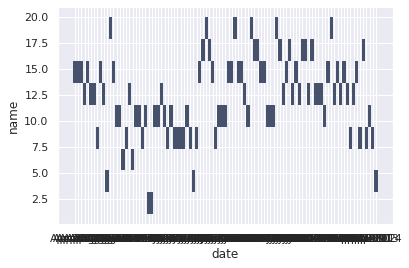

In [ ]:
import matplotlib.pyplot as plt
data = party_list_subset_df.groupby('date')['name'].count().reset_index()
sns.histplot(data=data, x='date', y='name')

In [ ]:
party_list_subset_df.head()

,date,name
0,Dec-2014,2014-the-thanksgiving-day-parade-from-the-grou...
1,Nov-2014,2014-gala-guests
2,Nov-2014,2014-equal-justice
3,Nov-2014,2014-celebrating-the-treasures
4,Nov-2014,2014-associates-and-friends


In [ ]:
#party_list_subset_df['hist'] = party_list_subset_df[['date', 'name']].apply(tuple, axis=1)
histogram = data.apply(tuple, axis=1).values.tolist()

In [ ]:
#histogram = [("Dec-2014", 1)] * 95  # Replace this fake answer with your real results

In [ ]:
grader.score('graph__histogram', histogram)

Your score: 1.0000


## Parsing captions


We now have all of the parties.  For each party, we'll need to get the captions, then find who appears in each caption. Let's start with a single party, [the benefit cocktails and dinner](https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2015/celebrating-the-neighborhood) for [Lenox Hill Neighborhood House](http://www.lenoxhill.org/), a neighborhood organization for the East Side. In our API, this corresponds to the party named `2015-celebrating-the-neighborhood`.  Let's get the captions for it.

In our API, the `/captions` endpoint takes a parameter `party`, which we give the name of the party we want. We can then extract the captions from the JSON it returns.

In [ ]:
import requests
response = requests.get('https://party-captions.tditrain.com/captions?party=2015-celebrating-the-neighborhood')
captions = response.json()['captions']
captions[0]

"Glenn Adamson, Simon Doonan, Victoire de Castellane, Craig Leavitt, Jerome Chazen, Andi Potamkin, Ralph Pucci, Kirsten Bailey, Edwin Hathaway, and Dennis Freedman at the Museum of Art and Design's annual MAD BALL. "

We'll need to do this for all of our parties later, so we should make it a function we can call. Take the party name as an argument and return the list of captions.

We want to avoid having to hit the API repeatedly the next time we need to run the notebook.  While you could save the files by hand, as we did before, a checkpoint library like [ediblepickle](https://pypi.python.org/pypi/ediblepickle/1.1.3) can handle this for you.  (Note, though, that you may not want to enable this until you are sure that your function is working.)

You should also keep in mind that HTTP requests fail occasionally, for transient reasons.  You should plan how to detect and react to these failures.   The [retrying module](https://pypi.python.org/pypi/retrying) is one way to deal with this.

In [ ]:
from retrying import retry
@retry
def get_captions(party_name):
    base = 'https://party-captions.tditrain.com/captions'
    params = {'party': party_name}
    captions = requests.get(base, params = params).json()['captions']
    #captions.strip()
    return captions

In [ ]:
#cap = get_captions('2015-sab-the-jewish-museum-roundabout-theatre-and-faces')
cap = get_captions('2014-fall-fun')
cap[15:25]

[' Mary Van Pelt and Melanie Chisholm ',
 ' Lindsey Pryor, Lucy Lamphere, Sheila Stephenson, and Betsy Bacon ',
 ' Nikki Brown and Kate Hemphill ',
 ' Maria Hernandez, Douglas Blonsky, and Kamie Lightburn ',
 ' Nina Griscom and Mark Gilbertson ',
 ' Dr. Marianne Engle, Susi Wunsch, and Cecilia Dupire ',
 ' Holly Hunt, Kamie Lightburn, and Stephanie Loeffler ',
 ' Nancy Mortimer, Jessica Tcherepnine, and Anne Ekstrom ',
 " Sheila Stephenson and Lily O'Boyle ",
 ' Natalie Pray, Helen Fitzgerald, Lucy Day, and Sharon Casdin ']

If things have gone according to plan, this should get the same captions as before.

In [ ]:
# This cell is expecting get_captions to return a list of the captions themselves
# Other routes to a solution might need to adjust this cell a bit
grader.check(get_captions('2015-celebrating-the-neighborhood') == captions)

True

Now that we have some sample captions, let's start parsing names out of those captions.  There are many ways of going about this, and we leave the details up to you.  Some issues to consider:

  1. Some captions are not useful: they contain long narrative texts that explain the event.  Try to find some heuristic rules to separate captions that are a list of names from those that are not.  A few heuristics include:
    - Look for sentences (which have verbs) and as opposed to lists of nouns. For example, [`nltk` does part of speech tagging](http://www.nltk.org/book/ch05.html) but it is a little slow. There may also be heuristics that accomplish the same thing.
    - Similarly, spaCy's [entity recognition](https://spacy.io/docs/usage/entity-recognition) could be useful here, but like `nltk` using `spaCy` will add to processing time.
    - Look for commonly repeated threads (e.g. you might end up picking up the photo credits or people such as "a friend").
    - Long captions are often not lists of people.  The cutoff is subjective, but for grading purposes **we set that cutoff at 250 characters**.
  1. Many of the captions contain extraneous whitespace or other formatting issues you may need to deal with.
  1. You will want to separate the captions based on various forms of punctuation.  Try using `re.split`, which is more sophisticated than `string.split`. **Note**: The reference solution uses regex exclusively for name parsing.
  1. You might find a person named "ra Lebenthal".  There is no one by this name.  Any idea what might cause that?
  1. This site is pretty formal and likes to say things like "Mayor Michael Bloomberg" after his election but "Michael Bloomberg" before his election.  Can you find other ('optional') titles that are being used?  They should probably be filtered out because they ultimately refer to the same person: "Michael Bloomberg."
  1. There is a special case you might find where couples are written as e.g. "John and Mary Smith". You will need to write some extra logic to make sure this properly parses to two names: "John Smith" and "Mary Smith".
  1. When parsing names from captions, it can help to look at your output frequently and address the problems that you see coming up, iterating until you have a list that looks reasonable. This is the approach used in the reference solution. Because we can only asymptotically approach perfect identification and entity matching, we have to stop somewhere.
  1. Your eye is very good at doing this sort of parsing.  You will find it helpful to look at a caption and the names you parse of out it. Do this for a selection of captions to detect potential issues.
  1. You want to keep the names in a caption together - that's how we can tell they're connected to each other! You should get one list of names for each caption.
  
**Questions worth considering:**
  1. Who is Patrick McMullan and should he be included in the results? How would you address this?
  2. What else could you do to improve the quality of the graph's information?

In [ ]:
# You will want to make a function that takes in a caption and returns a list of names
#import re
import regex as re
import spacy
nlp = spacy.load("en_core_web_sm")

def get_names(cap):
    cap = cap.strip()
    cap = cap.replace("&","and")
    cap = re.sub(' +', ' ',  cap)

    if len(cap)<=250:
        regex = r'[A-Z][a-z]+ (?:[A-Z][a-z]+-? ?)?[A-Z][a-z]+(?:[A-Z][a-z]+)?'
        regex_x = r'[A-Z][a-z]+ [A-Z]. [A-Z][a-z]+'
        regex_c = r'(?<![A-Z][a-z]+ )[A-Z][a-z]+\s?[^,]\sand\s[A-Z][a-z]+ [A-Z][a-z]+'

        names = re.findall(regex,cap)
        c_names = re.findall(regex_c, cap)
        ans_names = []

        for n in names:
    #         print("n in names is ", n)
            if (len(n.split(" "))) <= 2:
                ans_names.append(n)
            elif (len(n.split(" "))) > 2:
                doc = nlp(n).ents
                if len(doc)>0:
                   # print(">>>>>>>doc is ", doc[0].text," ", doc[0].label_)
                    if doc[0].label_ == "PERSON":
                        ans_names.append(n)
            else:
                print(f"This n has a weird length {n}")

        names_x = re.findall(regex_x, cap)
        for x in names_x:
            if (len(x.split(" "))) <= 2:
                ans_names.append(x)
            elif (len(x.split(" "))) > 2:
                doc = nlp(x).ents
                if len(doc)>0:
                    if doc[0].label_ == "PERSON":
                        ans_names.append(x)

        if len(c_names)>0:
            couple_names = re.split('\sand\s',c_names[0])
            couple_names_surname = re.split('\s',couple_names[1])
            combined_couple_name = f'{couple_names[0]} {couple_names_surname[1]}'
            #names.append(combined_couple_name)
            ans_names.append(combined_couple_name)

    return ans_names

## Question 2: sample_names


Once you feel that your algorithm is working well, parse all of the captions we got from the `2015-celebrating-the-neighborhood` party and extract all the names mentioned.  Sort them alphabetically, by first name, and return the first hundred.

In [ ]:
cap = get_captions('2015-celebrating-the-neighborhood')
print(type(cap))
all_names = []
for c in cap:
    #names = refine_names(c)
    names = get_names(c)
    #names = get_simple_names(c)
    all_names.append(names)

<class 'list'>


In [ ]:
cap = get_captions('2015-celebrating-the-neighborhood')
sample_names_pre = [s for ss in all_names for s in ss]
sample_names=sorted(list(set(sample_names_pre)))[:100]

In [ ]:
#sample_names = ["Caroline Dean"] * 100

grader.score('graph__sample_names', sample_names)

Your score: 0.9500


Now, test your tools on a few other parties.  You will probably find that other parties have new issues in their captions that trip up your caption parser.  But don't worry if the parser isn't perfect - just try to get the easy cases for now. You may need to come back and refine it more for the later questions, however.

## Parsing all the parties


Once you are satisfied that your parser is working, we want to run it for all of our parties. First, get the captions for all of the parties in our party list. If you haven't implemented some caching of the captions, you probably want to do this first.

In [ ]:
# It may take several minutes to fetch all the captions

all_captions=[]
for p in party_list_subset_df['name']:
    caps = get_captions(str(p))
    capStrip = list(map(lambda s:s.strip(), caps))
    all_captions.append(capStrip)

In [ ]:
all_new_captions = [c for cap in all_captions for c in cap if len(c)>0 ]

In [ ]:
len(all_new_captions)

106306

And parse the names in each caption.

In [ ]:
# You should have a list of names for each caption
# Depending on how you set up your parser, this may take quite a while

You should end up with over 100,000 captions and roughly 110,000 names.

## Building the graph

For the remaining analysis, we think of the problem in terms of a
[network](http://en.wikipedia.org/wiki/Computer_network) or a
[graph](https://en.wikipedia.org/wiki/Graph_%28discrete_mathematics%29).  Any time a pair of people appear in a caption together, that is considered a link.  What we have described is more appropriately called an (undirected)
[multigraph](http://en.wikipedia.org/wiki/Multigraph) with no self-loops, but this has an obvious analog in terms of an undirected [weighted graph](http://en.wikipedia.org/wiki/Graph_%28mathematics%29#Weighted_graph).

In the remainder of this miniproject, we will analyze the social graph of the New York social elite.  We recommend using python's [`networkx`](https://networkx.github.io/) library to build this social graph.

In [ ]:
######Trying to just get the frequency here then peop_connections could be directly used edge creation
from itertools import combinations
import networkx as nx

peop_connections=[]

for cap in all_new_captions:
    #unq_names = set(refine_names(str(cap)))
    unq_names = set(get_names(str(cap)))
    comb = list(combinations(unq_names, 2))
    if (len(comb)>0):
        peop_connections.append(comb)

In [ ]:
all_connections_flattened

[('Aalika Mahindra', 'Jorge Zapata'),
 ('Aaliyah Bell', 'Marcia Gowen'),
 ('Aamba Chavis', 'Bonnie Young'),
 ('Aarik Singh', 'Vinayak Singh'),
 ('Aarola Jain', 'Evans Jain'),
 ('Aarola Jain', 'Kim Heirston-Evans'),
 ('Aaron Adler', 'Nick Mautone'),
 ('Aaron Adler', 'Noah Adler'),
 ('Aaron Adler', 'Noah Adler'),
 ('Aaron Amaro', 'Libby Gray'),
 ('Aaron Baldinger', 'Mililani Trent'),
 ('Aaron Curti', 'Jan Linhart'),
 ('Aaron Curti', 'Judy Ann Hasel'),
 ('Aaron Curti', 'Roger Chin'),
 ('Aaron Curti', 'Carol Nobbs'),
 ('Aaron Curti', 'Carol Nobbs'),
 ('Aaron Eckhart', 'Carrie Cloud'),
 ('Aaron Edwards', 'Andrew Embiricos'),
 ('Aaron Edwards', 'Anthony Davalos'),
 ('Aaron Fedor', 'Tori Golub'),
 ('Aaron Fedor', 'Luke Fedor'),
 ('Aaron Fisher', 'Elizabeth Mayhew'),
 ('Aaron Fisher', 'Mary Pulido'),
 ('Aaron Forem', 'Brian Topken'),
 ('Aaron Forem', 'Mark Rosenberg'),
 ('Aaron Fossi', 'Maureen B. Whitaker'),
 ('Aaron Fossi', 'David Atterbury'),
 ('Aaron Fuller', 'Douglas Katz'),
 ('Aaron Full

In [ ]:
from collections import Counter

all_connections_flattened = [ i for pc in peop_connections for i in pc ]
all_connections_flattened = sorted(all_connections_flattened, key = lambda x: x[0])

G = nx.Graph()

histogram_all_connections = Counter(all_connections_flattened)

for p1, p2 in histogram_all_connections:
    G.add_edge(p1,p2, weight = histogram_all_connections[(p1, p2)])

In [ ]:
import pickle

# save graph object to file
pickle.dump(G, open('mynetwork.pickle', 'wb'))

# load graph object from file
#G = pickle.load(open('filename.pickle', 'rb'))

You should find you have roughly 200,000 distinct pairs of people appearing in photos together - corresponding to how many (weighted) edges there are in our graph.

## Question 3: degree


The simplest question to ask is "who is the most popular"?  The easiest way to answer this question is to look at how many connections everyone has.  Return the top 100 people and their degree.  Remember that if an edge of the graph has weight 2, it counts for 2 in the degree.

**Checkpoint:** Some aggregate stats on the solution:
    
    count:  100.0
    mean:   202.2
    std:     94.1
    min:    132.0
    25%:    146.8
    50%:    169.5
    75%:    212.0
    max:    713.0
    
Note that these checkpoints are guidelines, you may not match them exactly.

In [ ]:
X = sorted(G.degree, key=lambda x: x[1], reverse=True)
print(type(X[0:10]))

<class 'list'>


In [ ]:
df = pd.DataFrame(X[0:100])
print(df.describe())

                1
count  100.000000
mean   138.810000
std     54.256163
min     92.000000
25%    102.750000
50%    125.000000
75%    153.500000
max    443.000000


In [ ]:
import heapq  # Heaps are efficient structures for tracking the largest
              # elements in a collection.  Use introspection to find the
              # function you need.
#degree = [('Alec Baldwin', 144)] * 100

degree = X[0:100]

grader.score('graph__degree', degree)

Your score: 0.9000


## Question 4: PageRank


A similar way to determine popularity is to look at their
[PageRank](http://en.wikipedia.org/wiki/PageRank).  PageRank is used for web ranking and was originally
[patented](http://patft.uspto.gov/netacgi/nph-Parser?patentnumber=6285999) by Google and is essentially the stationary distribution of a [Markov
chain](http://en.wikipedia.org/wiki/Markov_chain) implied by the social graph. You can implement this yourself or use the version in `networkx`.

Use 0.85 as the damping parameter so that there is a 15% chance of jumping to another vertex at random.

**Checkpoint:** Some aggregate stats on the solution:


    count:  100.000000
    mean:     0.000193
    std:      0.000080
    min:      0.000130
    25%:      0.000144
    50%:      0.000169
    75%:      0.000206
    max:      0.000646


In [ ]:
pagerank_pre = nx.pagerank(G, alpha=0.85)

In [ ]:
pagerank = list(sorted(pagerank_pre.items(), key=lambda item: item[1], reverse=True))[:100]

In [ ]:
df = pd.DataFrame(pagerank)
print(df.describe())

                1
count  100.000000
mean     0.000206
std      0.000083
min      0.000138
25%      0.000154
50%      0.000183
75%      0.000226
max      0.000660


In [ ]:
#pagerank = [('Martha Stewart', 0.00019312108706213307)] * 100

grader.score('graph__pagerank', pagerank)

Your score: 0.9100


## Question 5: best_friends


Another interesting question is who tend to co-occur with each other.  Give us the 100 edges with the highest weights.

Google these people and see what their connection is.  Can we use this to detect instances of infidelity?

**Checkpoint:** Some aggregate stats on the solution:

    count:  100.0
    mean:    27.5
    std:     16.9
    min:     14.0
    25%:     17.0
    50%:     21.5
    75%:     31.3
    max:    122.0

In [ ]:
all_edges_with_weights = []

for (u, v, wt) in G.edges.data('weight'):
    #print(f"({u}, {v}, {wt})")
    all_edges_with_weights.append(((u, v), wt))

In [ ]:
all_edges_with_weights.sort(key=lambda a: a[1], reverse=True)

In [ ]:
df = pd.DataFrame(all_edges_with_weights[0:100])
df.describe()

,1
count,100.000000
mean,23.790000
std,17.232395
min,13.000000
25%,14.750000
50%,17.000000
75%,24.250000
max,121.000000


In [ ]:
#best_friends = [(('Michael Kennedy', 'Eleanora Kennedy'), 41)] * 100
best_friends = all_edges_with_weights[0:100]
grader.score('graph__best_friends', best_friends)

Your score: 0.9300


*Copyright &copy; 2022 Pragmatic Institute. This content is licensed solely for personal use. Redistribution or publication of this material is strictly prohibited.*